
This notebook is structured as follows: 
1. [Read the Data](#data)
2. [Trading Strategy](#tradingstrategy)
3. [Trade Level Analytics](#tradelevelanalytics)
4. [Performance Analysis](#performance)
5. [Conclusion and Next Steps](#conclusion)

## Import Libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# Import the 'datetime' module to work with date and time objects in Python
import datetime

# For data visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

<a id='data'></a>
## Read the Data

We have saved the FOMC sentiment score data in a CSV file named `fomc_sentiment_score_spy_ohlc_jan22_to_jul24.csv`. You can read the file using the `read_csv()` method of the `pandas` library. 

In [2]:
# Read the CSV file into a pandas DataFrame, setting the first column as the index
sentiment_score = pd.read_csv(
    '../data_modules/fomc_sentiment_score_spy_ohlc_jan22_to_jul24.csv',
    index_col=0)

# Convert the index to datetime format for accurate time-based operations
sentiment_score.index = pd.to_datetime(sentiment_score.index)

# Display the first few rows of the DataFrame to check its structure and content
sentiment_score.head()

,text,video_id,open,high,low,close,sentiment_score
timestamp,,,,,,,
2022-01-26 19:30:00+00:00,"Good afternoon. At the Federal Reserve, we are...",21,441.480,441.6151,440.76,441.2700,0.395239
2022-01-26 19:31:00+00:00,Omicron variant will surely weigh on economic ...,21,441.276,441.6700,440.27,440.6195,-0.119169
2022-01-26 19:32:00+00:00,"the past three months. Over the past year, pay...",21,440.630,441.0800,440.31,440.5300,-0.050996
2022-01-26 19:33:00+00:00,well above our longer- run goal of 2 percent. ...,21,440.580,440.7000,439.80,440.0100,-0.278648
2022-01-26 19:34:00+00:00,we believe that the best thing we can do to su...,21,439.970,440.2840,438.42,438.9479,0.458311


<a id='tradingstrategy'></a>
## Trading Strategy

A long position can be taken when the rolling mean of the sentiment score of the FOMC report is more than a certain threshold. Similarly, a short position can be taken if the rolling mean of the sentiment score is less than the threshold. In this notebook, we will backtest this trading strategy with a sentiment score threshold of 0.1 for long positions and -0.1 for short positions. 





In [3]:
# Create a dataframe 'trade_sheet' to store the trades
trade_sheet = pd.DataFrame()

In [4]:
# Initialise the current_position as '0'
current_position = 0

In [5]:
# Define a variable to store the trade's entry date and time
entry_datetime = ''

# Define a variable to store the long entry price
entry_price = ''

# Define a variable to store the trade's exit date and time
exit_datetime = ''

# Define a variable to store the long exit price
exit_price = ''

In [6]:
# Use 0.1 as a threshold 
sentiment_score_threshold = 0.1

In [7]:
# Iterate over the dates in the dataframe 'data'
for i in sentiment_score.video_id.unique():
    video = sentiment_score[sentiment_score['video_id'] == i]
    video['rolling_sentiment_score'] = video['sentiment_score'].expanding(
    ).mean()

    for timestamp in video.index:

        # We will enter the long position if we are not holding any position and the entry condition is met
        if current_position == 0 and timestamp != video.index[-1]:
            if (video.loc[timestamp]['rolling_sentiment_score']
                    > sentiment_score_threshold):
                print('________________')
                print('opening long position at ', timestamp)

                # Define the variable 'entry_date'
                entry_datetime = timestamp

                # Extract the 'Close price' of the current_date and store it the variable 'entry price'
                entry_price = video.loc[entry_datetime, 'close']

                # Long position is opened so update the current_position to '1'
                current_position = 1

            elif (video.loc[timestamp]['rolling_sentiment_score']
                  < -sentiment_score_threshold):
                print('opening short position at ', timestamp)

                # Define the variable 'entry_date'
                entry_datetime = timestamp

                # Extract the 'Close price' of the current_date and store it the variable 'entry price'
                entry_price = video.loc[entry_datetime, 'close']

                # Long position is opened so update the current_position to '1'
                current_position = -1

        # We will exit the long position if we are holding a long position and the exit condition is met
        elif current_position == 1 and (
            (video.loc[timestamp]['rolling_sentiment_score']
             < -sentiment_score_threshold) or (timestamp == video.index[-1])):

            print('closing long position at ', timestamp)

            # Define the variable 'exit_date'
            exit_datetime = timestamp

            # Extract the 'Close price' on the current_date and store in the variable 'exit price'
            exit_price = video.loc[exit_datetime, 'close']

            # Append the details of this trade to the 'trade_sheet' dataframe
            trade_sheet = trade_sheet.append(
                [(current_position, entry_datetime, entry_price, exit_datetime,
                  exit_price)],
                ignore_index=True)

            # Long position is closed so update the current_position to '0'
            current_position = 0

        # We will exit the long position if we are holding a long position and the exit condition is met
        elif current_position == -1 and (
            (video.loc[timestamp]['rolling_sentiment_score']
             > sentiment_score_threshold) or (timestamp == video.index[-1])):

            print('closing short position at ', timestamp)

            # Define the variable 'exit_date'
            exit_datetime = timestamp

            # Extract the 'Close price' on the current_date and store in the variable 'exit price'
            exit_price = video.loc[exit_datetime, 'close']

            # Append the details of this trade to the 'trade_sheet' dataframe
            trade_sheet = trade_sheet.append(
                [(current_position, entry_datetime, entry_price, exit_datetime,
                  exit_price)],
                ignore_index=True)

            # Long position is closed so update the current_position to '0'
            current_position = 0

# Define the names of columns in 'trade_sheet' dataframe
trade_sheet.columns = [
    'Position', 'Entry Datetime', 'Entry Price', 'Exit Datetime', 'Exit Price'
]
trade_sheet['pnl'] = trade_sheet['Position'] * (trade_sheet['Exit Price'] -
                                                trade_sheet['Entry Price'])

trade_sheet.tail()

________________
opening long position at  2022-01-26 19:30:00+00:00
closing long position at  2022-01-26 19:36:00+00:00
________________
opening long position at  2022-03-16 18:30:00+00:00
closing long position at  2022-03-16 18:33:00+00:00
________________
opening long position at  2022-05-04 18:30:00+00:00
closing long position at  2022-05-04 18:36:00+00:00
________________
opening long position at  2022-06-15 18:30:00+00:00
closing long position at  2022-06-15 18:38:00+00:00
________________
opening long position at  2022-07-27 18:30:00+00:00
closing long position at  2022-07-27 18:36:00+00:00
________________
opening long position at  2022-09-21 18:30:00+00:00
closing long position at  2022-09-21 18:31:00+00:00
________________
opening long position at  2022-11-02 18:30:00+00:00
closing long position at  2022-11-02 18:31:00+00:00
________________
opening long position at  2022-12-14 19:30:00+00:00
closing long position at  2022-12-14 19:38:00+00:00
________________
opening long po

,Position,Entry Datetime,Entry Price,Exit Datetime,Exit Price,pnl
13,1,2024-01-31 19:30:00+00:00,485.950,2024-01-31 19:35:00+00:00,486.73,0.780
14,1,2024-03-20 18:30:00+00:00,517.450,2024-03-20 18:37:00+00:00,517.22,-0.230
15,1,2024-05-01 18:30:00+00:00,502.930,2024-05-01 18:36:00+00:00,502.81,-0.120
16,1,2024-06-12 18:30:00+00:00,542.815,2024-06-12 18:37:00+00:00,542.52,-0.295
17,1,2024-07-31 18:30:00+00:00,551.520,2024-07-31 18:35:00+00:00,550.89,-0.630


<a id='tradelevelanalytics'></a>

## Trade Level Analytics

Generate performance analytics for a trading strategy using the `trade_analytics` function to calculate various trade level statistics. This function generated the following statistics. 

* Computes the total profit/loss (PnL), the number of total trades (long positions), and the count of winning and losing trades.

* Calculates the win and loss percentages and the average PnL for winning and losing trades. 
* The holding period for each trade is determined by the time difference between entry and exit, and the average holding time is computed. 

Save the output dataframe with trade level analytics in the `trade_level_analytics` dataframe.

In [8]:
def trade_analytics(trade_sheet):

    # Create a DataFrame to hold analytics, indexed by the strategy name
    analytics = pd.DataFrame(index=['Strategy'])

    # Calculate the total P&L (profit and loss) for the strategy and add it to the analytics DataFrame
    analytics['Total pnl'] = np.round(trade_sheet.pnl.sum(), 2)

    # Calculate the total number of trades by counting the rows where a position was taken (Position == 1)
    analytics['total_trades'] = len(trade_sheet.loc[trade_sheet.Position == 1])

    # Count the number of winning trades where P&L is greater than 0
    analytics['Number of Winners'] = len(trade_sheet.loc[trade_sheet.pnl > 0])

    # Count the number of losing trades where P&L is less than or equal to 0
    analytics['Number of Losers'] = len(trade_sheet.loc[trade_sheet.pnl <= 0])

    # Calculate the win percentage as the ratio of winners to total trades
    analytics['Win (%)'] = np.round(
        100 * analytics['Number of Winners'] / analytics.total_trades, 2)

    # Calculate the loss percentage as the ratio of losers to total trades
    analytics['Loss (%)'] = np.round(
        100 * analytics['Number of Losers'] / analytics.total_trades, 2)

    # Calculate the average P&L per winning trade
    analytics['per_trade_pnl_winners'] = np.round(
        trade_sheet.loc[trade_sheet.pnl > 0].pnl.mean(), 2)

    # Calculate the average P&L per losing trade, using the absolute value to ensure positive numbers
    analytics['per_trade_pnl_losers'] = np.round(
        np.abs(trade_sheet.loc[trade_sheet.pnl <= 0].pnl.mean()), 2)

    # Convert the 'Entry Datetime' and 'Exit Datetime' columns to datetime format in the 'trades' DataFrame
    trade_sheet['Entry Datetime'] = pd.to_datetime(
        trade_sheet['Entry Datetime'])
    trade_sheet['Exit Datetime'] = pd.to_datetime(trade_sheet['Exit Datetime'])

    # Calculate the holding period for each trade (time between entry and exit)
    holding_period = trade_sheet['Exit Datetime'] - trade_sheet[
        'Entry Datetime']

    # Calculate the average holding period across all trades and add it to the analytics DataFrame
    analytics['Average holding time'] = holding_period.mean()

    # Transpose the analytics DataFrame for a better display format (rows become columns)
    analytics = analytics.T

    return analytics


trade_level_analytics = trade_analytics(trade_sheet)
trade_level_analytics

,Strategy
Total pnl,0.5
total_trades,18
Number of Winners,7
Number of Losers,11
Win (%),38.89
Loss (%),61.11
per_trade_pnl_winners,1.37
per_trade_pnl_losers,0.82
Average holding time,0 days 00:05:10


### Update Trading Signals in DataFrame

Based on the trades information in the `trade_sheet`, update the signal date of SPY ETF at minute frequency. This data will be used to do performance analysis of the strategy. To start with , import the file `spy_ohlc_jan22_to_jul24.csv` which contains the OHLC data at one-minute frequency. 



In [9]:
# Import the minute-level data from a CSV file
minute_data = pd.read_csv('../data_modules/spy_ohlc_jan22_to_jul24.csv')

# Convert the 'timestamp' column to datetime format and set it as the DataFrame index
minute_data.index = pd.to_datetime(minute_data.timestamp)

# Initiate the 'signal' column
minute_data['signal'] = 0

# Display the first few rows of the DataFrame to verify the data is loaded correctly
minute_data.head()

,timestamp,open,high,low,close,signal
timestamp,,,,,,
2022-01-26 00:00:00+00:00,2022-01-26 00:00:00+00:00,435.17,435.22,435.15,435.15,0
2022-01-26 00:01:00+00:00,2022-01-26 00:01:00+00:00,435.13,435.13,434.80,434.80,0
2022-01-26 00:02:00+00:00,2022-01-26 00:02:00+00:00,434.83,434.96,434.80,434.96,0
2022-01-26 00:03:00+00:00,2022-01-26 00:03:00+00:00,434.86,434.86,434.66,434.66,0
2022-01-26 00:04:00+00:00,2022-01-26 00:04:00+00:00,434.55,434.55,434.23,434.30,0


The following function `update_signal_column` iterates over the `trade_sheet` DataFrame to update the `signal` column in the `minute_data` DataFrame. For each trade in `trade_sheet`, it extracts the entry and exit dates, as well as the position (e.g., -1 for short positions).

The function then updates the `signal` column in `minute_data` for the date range between the entry and exit dates with the corresponding position. This process helps in marking the periods during which certain trades were active in the `minute_data` DataFrame.

In [10]:
def update_signal_column(trade_sheet, data):

    # Iterate over each row in the 'trades' DataFrame
    for index, trade in trade_sheet.iterrows():

        # Extract the entry date of the trade
        entry_date = trade_sheet['Entry Datetime'][index]

        # Extract the exit date of the trade
        exit_date = trade_sheet['Exit Datetime'][index]

        # Extract the position of the trade (e.g., -1 for short)
        position = trade_sheet['Position'][index]

        # Update the 'signal' column in the 'data' DataFrame for the date range
        # between the entry date and the exit date with the corresponding position
        data.loc[entry_date:exit_date, 'signal'] = position

    return data


# Update the 'minute_data' DataFrame by applying the 'update_signal_column' function
minute_data = update_signal_column(trade_sheet, minute_data)

# Display the first few rows of the updated 'minute_data' to verify the signal column update
minute_data.head()

,timestamp,open,high,low,close,signal
timestamp,,,,,,
2022-01-26 00:00:00+00:00,2022-01-26 00:00:00+00:00,435.17,435.22,435.15,435.15,0
2022-01-26 00:01:00+00:00,2022-01-26 00:01:00+00:00,435.13,435.13,434.80,434.80,0
2022-01-26 00:02:00+00:00,2022-01-26 00:02:00+00:00,434.83,434.96,434.80,434.96,0
2022-01-26 00:03:00+00:00,2022-01-26 00:03:00+00:00,434.86,434.86,434.66,434.66,0
2022-01-26 00:04:00+00:00,2022-01-26 00:04:00+00:00,434.55,434.55,434.23,434.30,0


<a id='performance'></a>
## Performance Analysis

The following function `get_performance_metrics` will help to calculate the performance measures and analyse the strategy. We will be using this function in the upcoming sections too.

In [13]:
# Create a function to compute and plot the strategy returns
def get_performance_metrics(data):

    # Create a data to store performance metrics
    performance_metrics = pd.DataFrame(index=['Strategy'])

    # -------------------Plot equity curve---------------------

    # Calculate strategy returns
    data['strategy_returns'] = data.signal.shift(1) * data.close.pct_change()

    # Calculate cumulative strategy returns
    data['cumulative_returns'] = (data['strategy_returns'] + 1.0).cumprod()

    # Plot cumulative returns
    data['cumulative_returns'].plot(figsize=(15, 7), color='black')
    plt.title('Equity Curve', fontsize=14)
    plt.ylabel('Returns (in times)', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.show()

    # -------------------Compute CAGR---------------------

    # Total number of trading candles per day
    candle_difference = data.index.to_series().diff().mean().days
    if candle_difference >= 1:
        n = np.floor(candle_difference)
    else:
        n = data.loc[datetime.datetime.strftime(data.index[-1].date(),
                                                '%Y-%m-%d')].shape[0]

    # Total number of trading candles over time
    trading_candles = len(data['cumulative_returns'])

    # Calculate compound annual growth rate
    performance_metrics['CAGR'] = "{0:.2f}%".format(
        (data.cumulative_returns.iloc[-1]**(252 * n / trading_candles) - 1) *
        100)

    # -------------------Compute Sharpe ratio---------------------

    # Set a risk-free rate
    risk_free_rate = 0.02 / (252 * n)

    # Calculate Sharpe ratio
    performance_metrics['Sharpe Ratio'] = round(
        np.sqrt(252 * n) * (np.mean(data['strategy_returns']) -
                            (risk_free_rate)) /
        np.std(data['strategy_returns']), 2)

    # -------------------Compute maximum drawdown---------------------

    # Compute the cumulative maximum
    data['Peak'] = (data['strategy_returns'] + 1).cumprod().cummax()

    # Compute the Drawdown
    data['Drawdown'] = ((
        (data['strategy_returns'] + 1).cumprod() - data['Peak']) /
                        data['Peak']) * 100

    # Compute the maximum drawdown
    performance_metrics['Maximum Drawdown'] = "{0:.2f}%".format(
        (data['Drawdown'].min()))

    # -------------------Plot maximum drawdown---------------------

    # Plot maximum drawdown
    data['Drawdown'].plot(figsize=(15, 7), color='red')

    # Set the title and axis labels
    plt.title('Drawdowns', fontsize=14)
    plt.ylabel('Drawdown(%)', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.fill_between(data['Drawdown'].index,
                     data['Drawdown'].values,
                     color='red')
    plt.show()

    # Display performance metrics
    print(performance_metrics.T)

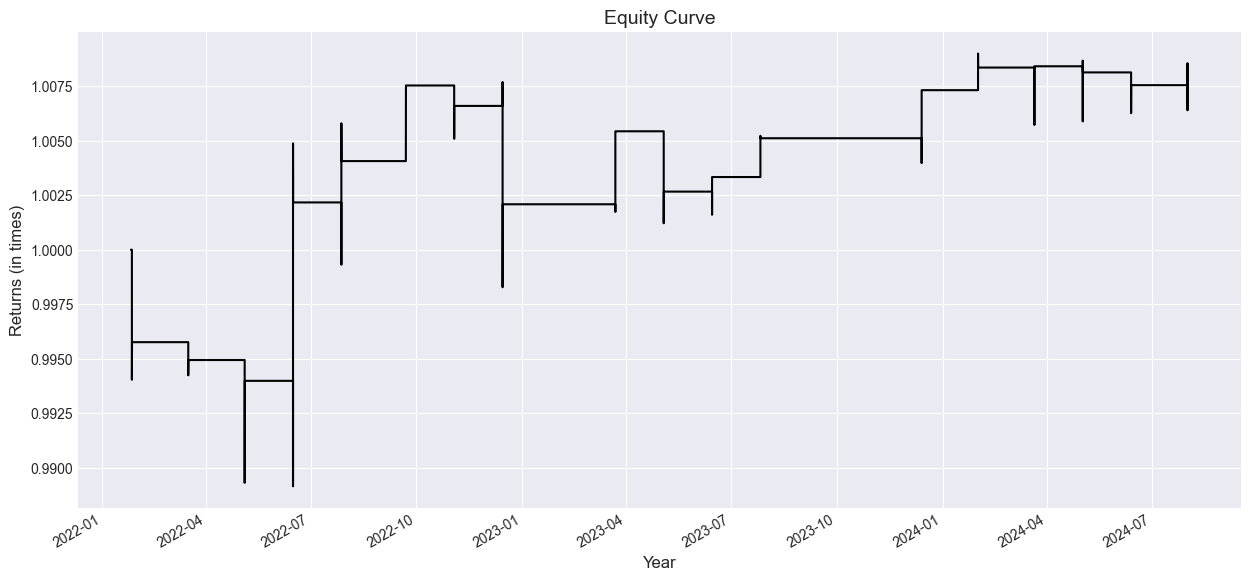

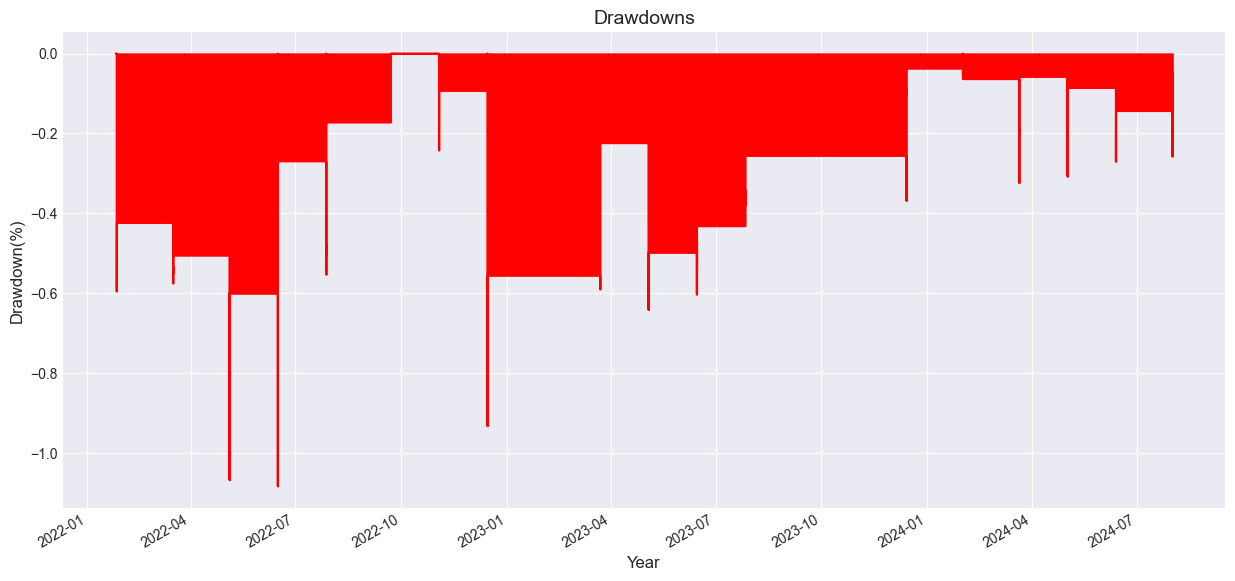

                 Strategy
CAGR                8.29%
Sharpe Ratio         0.96
Maximum Drawdown   -1.08%


In [14]:
# Call the get_performance_metrics function
get_performance_metrics(minute_data.dropna())

The strategy generated a Sharpe ratio of 0.96 with a maximum drawdown of 1.08%. 
<a id='conclusion'></a>

## Conclusion and Next Steps
In this notebook, you learnt to generate trading signals based on sentiment score threshold of FOMC transcripts and backtested it. In the upcoming notebooks, we will explore the variations of this strategy and study how the performance changes. <br><br>